# Deep Reinforcement Learning
## Deep Deterministic Policy Gradient (DDPG)
(by: [Nicolaj Stache](mailto:Nicolaj.Stache@hs-heilbronn.de), and [Pascal Graf](mailto:pascal.graf@hs-heilbronn.de), both: Heilbronn University, Germany, June 2022) 

In this notebook we solve reinforcement learning problems utilizing [DDPG](https://arxiv.org/abs/1509.02971) with networks created in Tensorflow.

The learning environments shown in this notebook have been created by **[OpenAI](https://openai.com/)**. OpenAI provides a library of diffrent reinforcement learning environments called **[Gym](https://www.gymlibrary.ml/)**.

<hr>

## Table of Contents:
### 1. [Imports](#imports)

### 2. [Environment](#environment)

### 3. [Training](#training)

### 4. [Evaluation](#evaluation)
<hr>

## 1. Imports <a class="anchor" id="imports"></a>

### Install OpenAI Gym
In order for this notebook to run you need to open a new terminal, activate your conda environment and install OpenAI Gym by typing `pip install -U gym`. You might also need to install PyGame which is used to render the environments by typing `pip install pygame`.

In [182]:
import gym
import numpy as np
import os
from collections import namedtuple, deque
from datetime import datetime
from tqdm import trange
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.initializers import glorot_normal, RandomUniform

## 2. Environment <a class="anchor" id="environment"></a>
The environment we're going to solve is called "Lunar Lander Continuous v2". 

<hr>

**LunarLanderContinuous-v2**

*This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.
Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.*

<hr>


First however, let's see how many environments are available to us. After finishing the Cart Pole environment feel free to try any other continuous environment (*BipedalWalker-v3* is recommended). Some environments might require additional packages like *mujoco* or *box2d* which can be installed using pip.

In [183]:
for key, val in gym.envs.registry.items():
    print(key)

CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
LunarLander-v2
LunarLanderContinuous-v2
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v1
CarRacingDomainRandomize-v1
CarRacingDiscrete-v1
CarRacingDomainRandomizeDiscrete-v1
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
Reacher-v2
Reacher-v4
Pusher-v2
Pusher-v4
InvertedPendulum-v2
InvertedPendulum-v4
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
Hopper-v2
Hopper-v3
Hopper-v4
Swimmer-v2
Swimmer-v3
Swimmer-v4
Walker2d-v2
Walker2d-v3
Walker2d-v4
Ant-v2
Ant-v3
Ant-v4
Humanoid-v2
Humanoid-v3
Humanoid-v4
HumanoidStandup-v2
HumanoidStandup-v4


### Open the Environment and start interacting

Now take a look at todays environment along with its so called action and state/observation space. The meaning of each value in the observation space can be looked up in the documentation

In [209]:
# Load the OpenAI Gym Environment
env = gym.make('LunarLanderContinuous-v2')


# Get action space and observation space sizes
print('''
----------------------------------------------
Action Space: {} Action Low / High: {} / {}
Observation Space: {}
----------------------------------------------
'''.format(env.action_space, env.action_space.low, env.action_space.high, env.observation_space.shape))

# Get a sample observation and action
print('''
----------------------------------------------
Sample Action: {}
Sample Observation: 
     Lander X & Y: {:.3f} {:.3f} 
     Lander Velocity X & Y: {:.3f} {:.3f} 
     Lander Angle: {:.3f} 
     Lander Angular Velocity: {:.3f}
     Lander Leg Contact: {} {}
----------------------------------------------
'''.format(env.action_space.sample(), *env.reset()))


----------------------------------------------
Action Space: Box(-1.0, 1.0, (2,), float32) Action Low / High: [-1. -1.] / [1. 1.]
Observation Space: (8,)
----------------------------------------------


----------------------------------------------
Sample Action: [ 0.61198133 -0.790548  ]
Sample Observation: 
     Lander X & Y: 0.004 1.421 
     Lander Velocity X & Y: 0.364 0.442 
     Lander Angle: -0.004 
     Lander Angular Velocity: -0.083
     Lander Leg Contact: 0.0 0.0
----------------------------------------------



The environment can also be rendered. Here, random actions are executed which will lead to a fast termination of the episode.

In [210]:
env = gym.make('LunarLanderContinuous-v2')
# Play some test episodes
for i_episode in range(5):
    observation = env.reset()
    episode_reward = 0
    for t in range(1000):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        episode_reward += reward
        if done:
            print("Episode finished after {} timesteps with a reward of {}".format(t+1, episode_reward))
            break
env.close()

Episode finished after 112 timesteps with a reward of -300.75509056094006
Episode finished after 116 timesteps with a reward of -130.45782356284025
Episode finished after 69 timesteps with a reward of -47.02327465550639
Episode finished after 141 timesteps with a reward of -67.37089094923799
Episode finished after 92 timesteps with a reward of -73.13906062292081


## 3. Training <a class="anchor" id="training"></a>

In this part of the notebook a DDPG algorithm is implemented and trained on the previously explored Gym environment. 

### Deep Deterministic Policy Gradient (DDPG) Pseudo Code


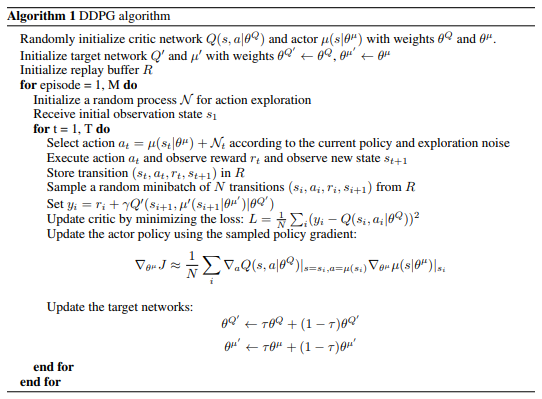

### DDPG Components

In order to implement DDPG we need multiple components which shall be implemented independently in an object oriented way.

- **DDPG Agent:** Class containing the neural networks, chooses actions given a state, manages the learning process given a batch from the replay buffer.
- **Replay Buffer:** Stores transitions $(s,a,r,s')$ and yields batches for training.
- **Tensorboard Logger:** Tracks the training process by logging different parameters at each training step.
- **Training Loop:** Just a function perfoming the interaction between the previously listed classes. 

### > DDPG Agent

**TODO:** 
- Build a dense network.
- Compile the built model.
- Implement the DDPG update functions for the actor and the critic.
- Implement a policy with random noise.

In [276]:
import time
class DDPGAgent:
    """
    DDPG Agent Class
    A Deep Deterministic Policy Gradient Agent capable of acting in a continuous action space 
    Gym environment utilizing a dense neural network and gaussian noise.
            
    """
    def __init__(self,
                 observation_shape: tuple,
                 action_shape: int,
                 action_low: int,
                 action_high: int,
                 sync_tau: float = 0.01,
                 epsilon: float = 0.25,
                 gamma: float = 0.95,
                 learning_rate_actor: float = 1e-3,
                 learning_rate_critic: float = 1e-3,
                 units: int = 32,
                 batch_size: int = 32                 
                 ):
        # Store the given parameters as class variables
        self.observation_shape = observation_shape
        self.action_shape = action_shape
        self.action_low = action_low
        self.action_high = action_high
        self.sync_tau = sync_tau
        self.epsilon = epsilon
        self.gamma = gamma
        self.learning_rate_actor = learning_rate_actor
        self.learning_rate_critic = learning_rate_critic
        self.units = units
        self.batch_size = batch_size
        self.training_steps = 0
        self.policy_loss = 0
        
        # Build the network model
        self.actor, self.critic = self._build_models(observation_shape, action_shape)
        
        # Create target models by cloning the existing networks
        self.actor_target = keras.models.clone_model(self.actor)
        self.actor_target.set_weights(self.actor.get_weights())
        self.critic_target = keras.models.clone_model(self.critic)
        self.critic_target.set_weights(self.critic.get_weights())
        
        # TODO: Compile the Critic using the Adam optimizer and the MSE loss with the given 
        # critic learning rate.
        self.critic_optimizer = Adam(learning_rate=self.learning_rate_critic)
        # TODO: Create an Adam optimizer with the actor critic learning rate.
        self.actor_optimizer = Adam(learning_rate=self.learning_rate_actor)

    def _build_models(self,
                      observation_shape: tuple,
                      action_shape: tuple) -> (keras.Model, keras.Model):
        # TODO: 
            # Build a dense Actor Network with two hidden layers.
            # Each layer should have "self.units" neurons and "relu" activation function.
            # The input size corresponds to the observation shape.
            # The output size corresponds to the action shape and should use "tanh" activation.
        input_layer = Input(shape=observation_shape)
        x = Dense(self.units, activation='relu')(input_layer)
        x = Dense(self.units, activation='relu')(x)
        output_layer = Dense(action_shape, activation='tanh', name="action")(x)
        actor = Model(input_layer, output_layer)
        actor.summary()
        
        # TODO: 
            # Build a dense Critic Network with two hidden layers.
            # Each layer should have "self.units" neurons and "relu" activation function.
            # The input consists of two branches corresponding to the observation shape 
            # and the action shape. The output size is 1.
        input_layer_state = Input(shape=observation_shape)
        input_layer_action = Input(shape=action_shape)
        x = Concatenate(axis=-1)([input_layer_state, input_layer_action])
        x = Dense(self.units, activation='relu')(x)
        x = Dense(self.units, activation='relu')(x)
        output_layer = Dense(1, name="value")(x)
        critic = Model(inputs=[input_layer_state, input_layer_action], outputs=output_layer)    
        critic.summary()
        return actor, critic

    def act(self,
            state: tuple):
        # TODO: Given the current state, return the actions.
        actions = self.actor(np.expand_dims(state, axis=0))
        noise = tf.random.normal(shape=[self.action_shape], mean=0.0, stddev=self.epsilon)
        actions += noise
        actions *= self.action_high
        actions = tf.clip_by_value(actions, self.action_low, self.action_high) 
        return actions[0]

    def learn(self,
              replay_batch: list) -> (float, float):        
        state_batch = replay_batch["state_batch"]
        action_batch = replay_batch["action_batch"]
        reward_batch = replay_batch["reward_batch"]
        next_state_batch = replay_batch["next_state_batch"]
        done_batch = replay_batch["done_batch"]
        
        # CRITIC TRAINING
        with tf.GradientTape() as tape:
            y = reward_batch + self.gamma * (1-done_batch.astype(int)) * \
                self.critic_target([next_state_batch, self.actor_target(next_state_batch)])
            value_loss = tf.math.reduce_mean(tf.math.square(y - self.critic([state_batch, action_batch])))
        critic_grad = tape.gradient(value_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic.trainable_variables))
        
        if self.training_steps % 2 == 1:
            # ACTOR TRAINING
            with tf.GradientTape() as tape:
                actions = self.actor(state_batch)
                critic_value = self.critic([state_batch, actions])
                self.policy_loss = -tf.math.reduce_mean(critic_value)
            actor_grads = tape.gradient(self.policy_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        
        
        # Soft synchronization between critic, actor and their target models.
        self.actor_target.set_weights([self.sync_tau * weights + (1.0 - self.sync_tau) * target_weights
                                           for weights, target_weights in zip(self.actor.get_weights(),
                                                                              self.actor_target.get_weights())])
        self.critic_target.set_weights([self.sync_tau * weights + (1.0 - self.sync_tau) * target_weights
                                            for weights, target_weights in zip(self.critic.get_weights(),
                                                                               self.critic_target.get_weights())])
        
        self.training_steps += 1

        return value_loss, self.policy_loss

### > Replay Buffer

The replay buffer is filled with experiences from the agent's interaction with the environment. On demand it returns a random batch of samples from the buffer.

**TODO:** Read and try to understand the following code.

In [277]:
class ReplayBuffer:
    def __init__(self,
                 capacity: int):
        self.buffer = deque(maxlen=capacity)
        self.collected_samples = 0

    def __len__(self):
        return len(self.buffer)
      
    def append(self, s, a, r, next_s, done):
        self.buffer.append({"state": s, "action":a, "reward":r, "next_state":next_s, "done":done})
        self.collected_samples += 1

    def sample(self,
               batch_size: int) -> dict:
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        replay_batch = [self.buffer[idx] for idx in indices]
        replay_batch = self.batch_to_arrays(replay_batch)
        self.collected_samples = 0
        return replay_batch
    
    def batch_to_arrays(self, replay_batch: list) -> dict:
        state_batch = np.zeros((len(replay_batch), *replay_batch[0]["state"].shape))
        action_batch = np.zeros((len(replay_batch), *replay_batch[0]["action"].shape))
        reward_batch = np.zeros((len(replay_batch), 1))
        next_state_batch = np.zeros((len(replay_batch), *replay_batch[0]["state"].shape))
        done_batch = np.zeros((len(replay_batch), 1), dtype=bool)
        
        for idx, sample in enumerate(replay_batch):
            state_batch[idx] = sample["state"]
            action_batch[idx] = sample["action"]
            reward_batch[idx] = sample["reward"]
            next_state_batch[idx] = sample["next_state"]
            done_batch[idx] = sample["done"]
            
        return {"state_batch": state_batch, "action_batch":action_batch, 
                "reward_batch": reward_batch, "next_state_batch": next_state_batch, 
                "done_batch": done_batch}

### > Tensorboard Logger
The tensorboard logger utilizes the tensorflow feature to log scalar values to an event file. This event file can be plotted by starting a tensorboard server in the local webbrowser by typing `tensorboard --logdir summaries` to a console.

**TODO:** Read and try to understand the following code.

In [278]:
class Logger:
    def __init__(self, log_dir="./summaries"):
        self.log_dir = log_dir
        self.writer = tf.summary.create_file_writer(log_dir)
        self.running_avg_dict = {}

    def log_scalar(self, tag, value, step):
        with self.writer.as_default():
            tf.summary.scalar(tag, value, step)

    def log_running_average(self, tag, value, run_avg_len=20):
        if tag not in self.running_avg_dict:
            self.running_avg_dict[tag] = deque(maxlen=run_avg_len)
        self.running_avg_dict[tag].append(value)

    def get_running_average(self, tag):
        return np.mean(self.running_avg_dict[tag])

### Training Parameters
**TODO:** Try different training parameters and see how they influence the convergence speed.

In [279]:
# Maximum Episodes Played
EPISODES = 5000
# Memorybatch Size
BATCH_SIZE = 128
# Discount Factor
GAMMA = 0.99
# Neurons per Dense layer
UNITS = 64
# Epsilon
EPSILON = 0.2
# Model Synchronization tau
SYNC_TAU = 0.005
# Adam learning rates
LEARNING_RATE_ACTOR = 1e-3
LEARNING_RATE_CRITIC = 1e-3

# Replay Buffer capacity and minimum size before training
BUFFER_CAPACITY = 100000
TRAINING_START_SIZE = 200

MAX_STEPS = 1000 # Don't change this parameter at all.

### > Training Loop

**TODO:** To monitor the training progress open a command line in your working directory and enter `tensorboard --logdir summaries`. 

In [ ]:
# Load the OpenAI Gym Environment.
env = gym.make('LunarLanderContinuous-v2')
  
# Create a DDPG Agent instance.
ddpg_agent = DDPGAgent(observation_shape=env.observation_space.shape, 
                       action_shape=env.action_space.shape[0],
                       action_low=env.action_space.low[0],
                       action_high=env.action_space.high[0],
                       sync_tau=SYNC_TAU,
                       units=UNITS,
                       epsilon=EPSILON,
                       learning_rate_actor=LEARNING_RATE_ACTOR,
                       learning_rate_critic=LEARNING_RATE_CRITIC,
                       batch_size=BATCH_SIZE)

# Create a Tensorboard Logger instance.
logging_name = datetime.strftime(datetime.now(), '%y%m%d_%H%M%S_DDPG')
logger = Logger(os.path.join("summaries", logging_name))

# Initialize a replay buffer instance.
replay_buffer = ReplayBuffer(BUFFER_CAPACITY)


# Run episodes in the environment
training_step = 0
# Save the best reward (averaged over 20 episodes)
best_avg_reward = -1000

t = trange(EPISODES, desc='', leave=True)   
for e in t:
    # Reset the environment and obtain the first observation
    state = env.reset()

    # Keep track of the summed reward
    episode_reward = 0

    for time_step in range(MAX_STEPS):
        # Choose an action.
        action = ddpg_agent.act(state)
        # Perform the action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)
        episode_reward += np.sum(reward)
        #env.render()
        # Append the current environment info to the replay buffer.
        replay_buffer.append(state, action, reward, next_state, done)
        # make next_state the new current state for the next frame.
        state = next_state

        # If enough samples have been collected acquire memories
        # from the replay buffer and use them for training.
        if len(replay_buffer) >= TRAINING_START_SIZE and time_step % 1 == 0:
                samples = replay_buffer.sample(BATCH_SIZE)
                value_loss, policy_loss = ddpg_agent.learn(samples)
                logger.log_scalar("Misc/ValueLoss", value_loss, training_step)
                logger.log_scalar("Misc/PolicyLoss", policy_loss, training_step)
                training_step += 1
        # If the episode is over break the loop and start with the next episode.
        if done:
            break

    # Print relevant information.
    t.set_description("episode: {}/{}, length: {:5.2f}, reward: {:5.2f}, training steps: {}"
          .format(e + 1, EPISODES, time_step, episode_reward, training_step))
    t.refresh()
    # Log the relevant parameters to the tensorboard.       
    logger.log_scalar("Performance/EpisodeLength", time_step, e)
    logger.log_scalar("Performance/Reward", episode_reward, e)
    logger.log_running_average("Reward", episode_reward)
    logger.log_running_average("EpisodeLength", time_step)
    logger.log_scalar("Misc/Epsilon", ddpg_agent.epsilon, e)
    logger.log_scalar("Misc/BufferLength", len(replay_buffer),e)
    
    # Store the best model.
    if(logger.get_running_average("Reward") > best_avg_reward):
        best_avg_reward = logger.get_running_average("Reward")
        ddpg_agent.critic.save(os.path.join("summaries", logging_name, logging_name + "_critic.h5"))
        ddpg_agent.actor.save(os.path.join("summaries", logging_name, logging_name + "_actor.h5"))
        
# NOTE: When the training has converged or the training takes too long it can be interrupted
# at any time. The progress in form of a neural network model will still be saved.

Model: "functional_234"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_179 (InputLayer)       [(None, 8)]               0         
_________________________________________________________________
dense_238 (Dense)            (None, 64)                576       
_________________________________________________________________
dense_239 (Dense)            (None, 64)                4160      
_________________________________________________________________
action (Dense)               (None, 2)                 130       
Total params: 4,866
Trainable params: 4,866
Non-trainable params: 0
_________________________________________________________________
Model: "functional_236"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_180 (InputLayer)    

episode: 37/5000, length: 288.00, reward: -174.86, training steps: 8402:   1%|    | 37/5000 [04:08<12:30:28,  9.07s/it]

### Testing
Let's test the network we trained on the environment.

In [268]:
# Load the OpenAI Gym Environment.
env = gym.make('LunarLanderContinuous-v2')
  
# Create a DDPG Agent instance.
ddpg_agent = DDPGAgent(observation_shape=env.observation_space.shape, 
                       action_shape=env.action_space.shape[0],
                       action_low=env.action_space.low[0],
                       action_high=env.action_space.high[0],
                       epsilon=0.0)

# TODO: Load your saved model
ddpg_agent.actor = keras.models.load_model(os.path.join("summaries", logging_name, logging_name + "_actor.h5"))

# Run episodes in the environment
for e in range(10):
    # Reset the environment and obtain the first observation
    state = env.reset()

    # Keep track of the summed reward
    episode_reward = 0

    for time_step in range(MAX_STEPS):
        env.render()
        # Choose an action.
        action = ddpg_agent.act(state)
        # Perform the action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)
        episode_reward += np.sum(reward)
        # make next_state the new current state for the next frame.
        state = next_state

        # If the episode is over break the loop and start with the next episode.
        if done:
            break
                
    print("episode: {}/{}, length: {:5.2f}, reward: {:5.2f}"
          .format(e + 1, 10, time_step, episode_reward))
env.close()

Model: "functional_226"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_173 (InputLayer)       [(None, 8)]               0         
_________________________________________________________________
dense_230 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_231 (Dense)            (None, 32)                1056      
_________________________________________________________________
action (Dense)               (None, 2)                 66        
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
_________________________________________________________________
Model: "functional_228"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_174 (InputLayer)    